In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importamos os o dataset e Convertemos os dados do 'Ingredientes'

In [ ]:
# codigos baseados nos exemplos do Gensim.
import numpy as np

with np.load('/content/drive/My Drive/simplified-recipes-1M.npz',allow_pickle=True) as data:
    recipes = data['recipes']
    ingredients = data['ingredients']
def getRecipes(Recipes):

    temp = ""
    # print(Recipes)
    for n in Recipes:
        temp += "{} ".format(n.replace(" ","_"))
    temp += "\n"
    return temp


## Salvamos um arquivo que vai ser usado no treinamento de um Word2Vec usando Gensim

In [ ]:
with open(
    "dataset.txt",
    mode="w"
) as dataset:
    for y in range(int(len(recipes)/4)): # usando apenas 1/4 das receitas para exemplo
        dataset.writelines(getRecipes(ingredients[recipes[y]]))
with open(
    "dataset.txt",
    mode="r"
) as dataset:
    for n in range(4):
      print(dataset.readlines())

In [ ]:
from gensim import utils
import gensim.models
class Training(object):
     def __iter__(self):
         file = open("dataset.txt")
         for line in file:
            yield utils.simple_preprocess(line)

## Um modelo Word2vec é treinado e salvo

um modelo Word2Vec tenta descobrir a relaçao entre palavras e as convertem em vetores que podem ser trabalhados.

In [ ]:
sentences = Training()
model = gensim.models.Word2Vec(sentences=sentences,workers=4)
model.wv.save("file")

In [ ]:
model = gensim.models.Word2Vec.load("/content/drive/My Drive/file3")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


## exemplo de similaridade entre ingredientes

os graficos abaixo representam a similaridade/relaçao entre os ingredientes numa escala de 0 a 1.0, sendo 1.0 mais similar e 0 menos similar. no exemplo abaixo é procurado os ingredientes mais similares aos ingredientes: eggs, salt e sugar.

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



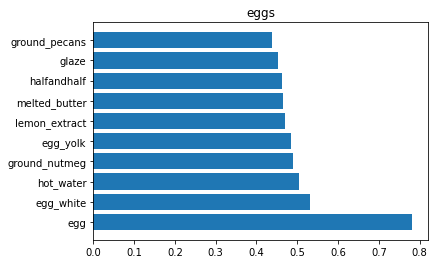

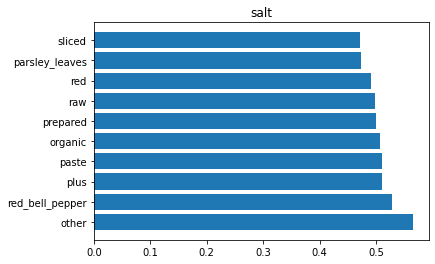

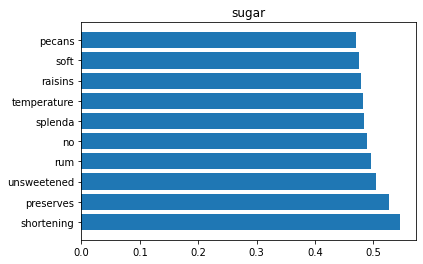

In [ ]:
def plot_example(text):
  import matplotlib.pyplot as plt
  dados = model.wv.most_similar(text)
  names = []
  values = []
  for x in dados:
    names.append(x[0])
    values.append(x[1])
  plt.barh(names,values,align='center')
  plt.title(text)
  plt.show()
plot_example("eggs")
plot_example("salt")
plot_example("sugar")

## Para a montagem do grafico utilizamos 2 metodos de reduçao: IncrementalPCA e t-SNE



o codigo abaixo foi montado com o objetivo de montar um grafico, onde, demonstre de forma geral quais ingredientes sao mais semelhantes. no grafico, cada ponto é um ingrediente e a distancia entre os pontos é a semelhança entre eles. como observado ha varios 'grupos' isolados de ingredientes que sao mais utilizados em receitas semelhantes.

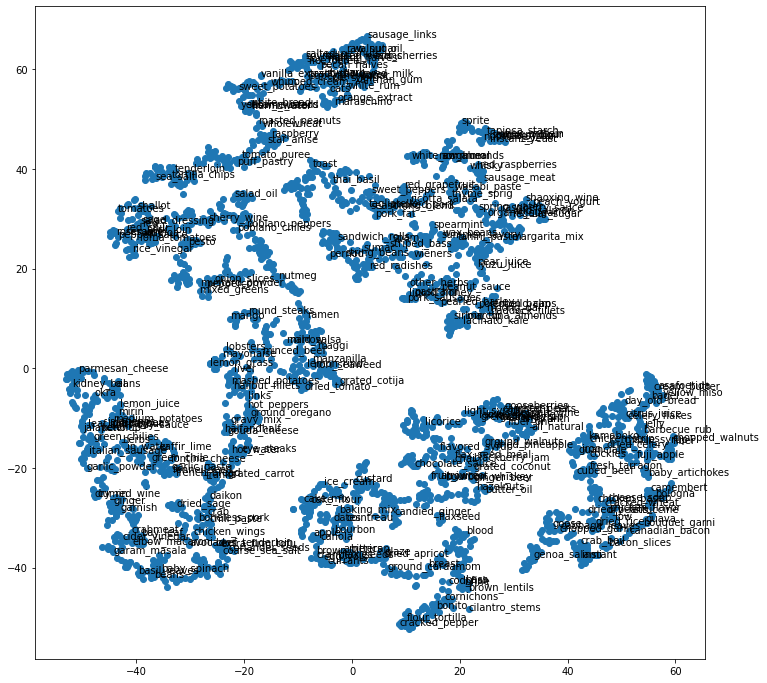

In [ ]:
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling
from IPython import get_ipython
from sklearn.decomposition import IncrementalPCA

def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    vectors = [] # positions in vector space
    labels = [] # keep track of words to label our data again later
    for word in model.wv.vocab:
        vectors.append(model.wv[word])
        labels.append(word)

    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    labels = np.asarray(labels)

    # reduce using IncrementalPCA
    vectors = np.asarray(vectors)
    tsne = IncrementalPCA(n_components=num_dimensions)    
    vectors = tsne.fit_transform(vectors)

    # reduce using t-SNE
    vectors = np.asarray(vectors)
    tsne = TSNE(n_components=num_dimensions, random_state=0)     #TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(model)

def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='markers', text=labels, marker=dict(
        size=16,
        color=[x_vals[x]*y_vals[x] for x in range(len(x_vals))], #set color equal to a variable
        colorscale='Viridis', # one of plotly colorscales
        showscale=True))
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')
def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 300)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

plot_with_matplotlib(x_vals, y_vals, labels)
